# Flight Delays Machine Learning Project

## Importing libraries und data

In [1]:
import pandas as pd
import math
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
flights = pd.read_csv('flights.csv')
flights.head()

/Users/calvin/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Data preparation

In [3]:
#Selection of range 32-42 to check data cleaning throughout the next steps 

flights.iloc [32:43]

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
32,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
33,2015,1,1,4,DL,95,N320US,SLC,ATL,140,...,725.0,10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
34,2015,1,1,4,NK,298,N514NK,LAS,IAH,144,...,630.0,-4.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
35,2015,1,1,4,HA,17,N389HA,LAS,HNL,145,...,610.0,15.0,0,0,NaN,0.0,0.0,15.0,0.0,0.0
36,2015,1,1,4,US,617,N804AW,ANC,PHX,152,...,905.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
37,2015,1,1,4,UA,1528,N76519,SJU,EWR,154,...,458.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
38,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,...,558.0,-35.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
39,2015,1,1,4,B6,304,N607JB,SJU,JFK,155,...,501.0,11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
40,2015,1,1,4,NK,451,N633NK,PBG,FLL,155,...,450.0,-33.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
41,2015,1,1,4,NK,972,N606NK,PHX,DFW,159,...,503.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#check for missing values 

flights.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

In [5]:
#Reduce DataFrame by keeping only relevant data

df = flights[["MONTH", "DAY", "DAY_OF_WEEK", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "SCHEDULED_DEPARTURE", "ARRIVAL_DELAY","CANCELLED"]]
df.isnull().sum()

MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
ARRIVAL_DELAY          105071
CANCELLED                   0
dtype: int64

In [6]:
#Assing 10 to every missing value as they represent canceled flights
#Number 10 is chosen as our limit, every flight with a delay ≥ 10 will be treated as late

df = df.fillna({"ARRIVAL_DELAY": 10})

In [7]:
#Add new column "effective delay" ≥ 10 min = 1 as dummy

df.loc[df.ARRIVAL_DELAY >= 10, 'EFFECTIVE_DELAY'] = '1' 
df.loc[df.ARRIVAL_DELAY < 10, 'EFFECTIVE_DELAY'] = '0' 

In [8]:
#Check modifications have been assigned correctly

df.iloc [32:43]

,MONTH,DAY,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,ARRIVAL_DELAY,CANCELLED,EFFECTIVE_DELAY
32,1,1,4,ANC,SEA,135,10.0,1,1
33,1,1,4,SLC,ATL,140,10.0,0,1
34,1,1,4,LAS,IAH,144,-4.0,0,0
35,1,1,4,LAS,HNL,145,15.0,0,1
36,1,1,4,ANC,PHX,152,-10.0,0,0
37,1,1,4,SJU,EWR,154,-11.0,0,0
38,1,1,4,ANC,SEA,155,-35.0,0,0
39,1,1,4,SJU,JFK,155,11.0,0,1
40,1,1,4,PBG,FLL,155,-33.0,0,0
41,1,1,4,PHX,DFW,159,1.0,0,0


In [9]:
#Reduce Dataframe to Christmas

df = df[df["MONTH"]==12]
df = df[df["DAY"]==25]

In [10]:
#Drop further now redundant columns

df = df.drop(columns= ["ARRIVAL_DELAY","MONTH","DAY","DAY_OF_WEEK","CANCELLED"])

In [11]:
#Reduce dataframe to have only 10 destination and origin airports

df2 = df[(df.DESTINATION_AIRPORT == "ATL")|(df.DESTINATION_AIRPORT == "ORD")|(df.DESTINATION_AIRPORT == "LAX")|(df.DESTINATION_AIRPORT == "DFW")|(df.DESTINATION_AIRPORT == "JFK")|(df.DESTINATION_AIRPORT == "DEN")|(df.DESTINATION_AIRPORT == "SFO")|(df.DESTINATION_AIRPORT == "LAS")|(df.DESTINATION_AIRPORT == "PHX")|(df.DESTINATION_AIRPORT == "IAH")]
df3 = df2[(df2.ORIGIN_AIRPORT == "ATL")|(df2.ORIGIN_AIRPORT == "ORD")|(df2.ORIGIN_AIRPORT == "LAX")|(df2.ORIGIN_AIRPORT == "DFW")|(df2.ORIGIN_AIRPORT == "JFK")|(df2.ORIGIN_AIRPORT == "DEN")|(df2.ORIGIN_AIRPORT == "SFO")|(df2.ORIGIN_AIRPORT == "LAS")|(df2.ORIGIN_AIRPORT == "PHX")|(df2.ORIGIN_AIRPORT == "IAH")]

In [12]:
#Quantization of departure hours to 24 values (hours) to improve accuracy in machine learning

for index, row  in df3.iterrows():
    df3.loc[index, "SCHEDULED_DEPARTURE"] = math.floor(row["SCHEDULED_DEPARTURE"]/100)
    

/Users/calvin/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
#Create dummy variables for the Airports

df3 = pd.get_dummies (df3, columns= ["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])

In [14]:
#Check modifications have been assigned correctly

df3.iloc [32:43]

,SCHEDULED_DEPARTURE,EFFECTIVE_DELAY,ORIGIN_AIRPORT_ATL,ORIGIN_AIRPORT_DEN,ORIGIN_AIRPORT_DFW,ORIGIN_AIRPORT_IAH,ORIGIN_AIRPORT_JFK,ORIGIN_AIRPORT_LAS,ORIGIN_AIRPORT_LAX,ORIGIN_AIRPORT_ORD,...,DESTINATION_AIRPORT_ATL,DESTINATION_AIRPORT_DEN,DESTINATION_AIRPORT_DFW,DESTINATION_AIRPORT_IAH,DESTINATION_AIRPORT_JFK,DESTINATION_AIRPORT_LAS,DESTINATION_AIRPORT_LAX,DESTINATION_AIRPORT_ORD,DESTINATION_AIRPORT_PHX,DESTINATION_AIRPORT_SFO
5712972,5,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5712976,5,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
5712986,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5712996,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5713036,5,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5713054,6,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
5713082,6,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5713086,6,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5713091,6,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5713113,6,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


## Build machine learning model

In [15]:
#train-test split of dataframe in 70%/30% ratio

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df3.drop('EFFECTIVE_DELAY', axis=1), df3['EFFECTIVE_DELAY'], test_size=0.3, random_state = 10)

In [16]:
#DataFrame containing the feature columns used for training

train_x.shape

(830, 21)

In [17]:
#DataFrame containing the feature columns used for testing

test_x.shape

(357, 21)

In [18]:
#Create a RandomForestClassifier object and train it

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=10)
model.fit(train_x, train_y)

/Users/calvin/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

## Accuracy Measurements

In [19]:
#Measure mean accuracy of the model

predicted = model.predict(test_x)
model.score(test_x,test_y)

0.6722689075630253

In [20]:
#Measure accuracy of the classification model with ROC AUC score

from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)
roc_auc_score(test_y, probabilities [:,1])

0.6213269800014439

In [21]:
#Generate an error matrix to measure the amount of correctly or incorrectly classified answers

from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[198,  45],
       [ 72,  42]])

In [22]:
#Measure the precision of the model

from sklearn.metrics import precision_score
train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions, average="binary", pos_label="1")

0.900990099009901

In [23]:
#Recall score to measure ability of the classifier to find all the positive samples

from sklearn.metrics import recall_score
recall_score(train_y, train_predictions, average="binary", pos_label="1")

0.7878787878787878

## Visualize model output

Text(0, 0.5, 'True Positive Rate')

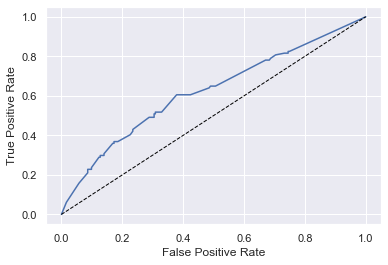

In [24]:
#Render roc curve to visualize accuracy of the classification model

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1], pos_label='1')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [40]:
#Function to predict the likelihood of a flight arriving on time 

def predict_delay(scheduled_departure, origin_airport, destination_airport):
    from datetime import datetime

    try:
        scheduled_departure_parsed = datetime.strptime(scheduled_departure, "%H:%M")
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    hour = scheduled_departure_parsed.hour

    input = [{'SCHEDULED_DEPARTURE': hour,
              'ORIGIN_AIRPORT_ATL': 1 if origin_airport == 'ATL' else 0,
              'ORIGIN_AIRPORT_ORD': 1 if origin_airport == 'ORD' else 0,
              'ORIGIN_AIRPORT_LAX': 1 if origin_airport == 'LAX' else 0,
              'ORIGIN_AIRPORT_DFW': 1 if origin_airport == 'DFW' else 0,
              'ORIGIN_AIRPORT_JFK': 1 if origin_airport == 'JFK' else 0,
              'ORIGIN_AIRPORT_DEN': 1 if origin_airport == 'DEN' else 0,
              'ORIGIN_AIRPORT_SFO': 1 if origin_airport == 'SFO' else 0,
              'ORIGIN_AIRPORT_LAS': 1 if origin_airport == 'LAS' else 0,
              'ORIGIN_AIRPORT_PHX': 1 if origin_airport == 'PHX' else 0,
              'ORIGIN_AIRPORT_IAH': 1 if origin_airport == 'IAH' else 0,
              'DESTINATION_AIRPORT_ATL': 1 if destination_airport == 'ATL' else 0,
              'DESTINATION_AIRPORT__ORD': 1 if destination_airport == 'ORD' else 0,
              'DESTINATION_AIRPORT__LAX': 1 if destination_airport == 'LAX' else 0,
              'DESTINATION_AIRPORT__DFW': 1 if destination_airport == 'DFW' else 0,
              'DESTINATION_AIRPORT__JFK': 1 if destination_airport == 'JFK' else 0,
              'DESTINATION_AIRPORT__DEN': 1 if destination_airport == 'DEN' else 0,
              'DESTINATION_AIRPORT__SFO': 1 if destination_airport == 'SFO' else 0,
              'DESTINATION_AIRPORT__LAS': 1 if destination_airport == 'LAS' else 0,
              'DESTINATION_AIRPORT__PHX': 1 if destination_airport == 'PHX' else 0,
              'DESTINATION_AIRPORT__IAH': 1 if destination_airport == 'IAH' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

In [41]:
predict_delay("12:45", "ATL", "ORD")

0.95

In [39]:
predict_delay(input("Please insert your scheduled departure time: "),input("which is your departure airport? "),input("where are you flying to? "))

Please insert your scheduled departure time: 14:00:00
which is your departure airport? ATL
where are you flying to? ORD


0.8833333333333332

In [28]:
while True:
    try:
        n = input("Please state your scheduled departure time: ")
        n = int(n)
    if: n > 22
        print ("oh no..")
        break
    except ValueError:
        print("No valid time! Please try again ...")

predict_delay(n,input("which is your departure airport? "),input("where are you flying to? "))

SyntaxError: invalid syntax (<ipython-input-28-658c6722fcb3>, line 5)